In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, log_loss
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import re
from sqlalchemy import create_engine
from imblearn.under_sampling import RandomUnderSampler
import random

# Set random seed
random.seed(42)
np.random.seed(42)

# Database connection setup
db_config = {
    'host': 'localhost',
    'database': 'postgres',
    'user': 'postgres',
    'password': 'kaviyam123',
    'port': '5432'
}

connection_string = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
engine = create_engine(connection_string)

query = 'SELECT * FROM public.overall_cleaned_base_and_pr_ef_policyef;'
data = pd.read_sql(query, con=engine)

selected_columns = ['policy no', 'renewal type', 'product name', 'product name 2',  'biztype', 'policy end date', 'policy start date', 
 'age', 'manufacturer/make', 'model', 'variant', 'vehicle segment', 'fuel type', 'rto location', 'vehicle idv', 'ncb amount', 'Cleaned Reg no', 
 'before gst add-on gwp', 'total od premium', 'total tp premium', 'gst', 'total premium payable', 
 'ncb % previous year', 'applicable discount with ncb', 'Cleaned Branch Name 2', 'Cleaned State2', 'Cleaned Zone 2', 'tie up',
 'Number of claims', 'approved', 'denied', 'corrected_name', 'customerid', 'Policy Status', 'Policy Tenure', 'Customer Tenure', 'New Customers', 'Claim Happaned/Not', 
 'Renewal Rate Status', 'withdrawn', 'chassis_engine_key', 'policy_wise_purchase']

data = data[selected_columns]

# Remove rows where 'Status' contains 'Open'
data = data[data['Policy Status'].isin(['Renewed', 'Not Renewed'])]


data['Policy Status'] = data['Policy Status'].apply(lambda x: 1 if x == 'Not Renewed' else 0)

for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = data[column].fillna('missing')
    else:
        data[column] = data[column].fillna(0)

date_columns = ['policy start date', 'policy end date']

for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

# Extract year, month, and day as separate features for all date columns
new_date_cols = {}
for col in date_columns:
    new_date_cols[f'{col}_YEAR'] = data[col].dt.year
    new_date_cols[f'{col}_MONTH'] = data[col].dt.month
    new_date_cols[f'{col}_DAY'] = data[col].dt.day

data = pd.concat([data, pd.DataFrame(new_date_cols)], axis=1)

# Drop date columns after splitting
data = data.drop(columns=date_columns)

# Define features and target
features = [col for col in data.columns if col not in ['Policy Status']]

# Define X (features) and y (target)
X = data[features]
y = data['Policy Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [2]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, log_loss, roc_curve
import matplotlib.pyplot as plt

# Initialize RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Apply Random Oversampling to the training data
X_train, y_train = ros.fit_resample(X_train, y_train)

In [3]:
# Apply label encoding to categorical features for both train and test sets
for column in X_train.columns:
    if X_train[column].dtype == 'object':
        # Initialize and fit the LabelEncoder on the training data
        label_encoder = LabelEncoder()
        X_train[column] = label_encoder.fit_transform(X_train[column].astype(str))

        # Create a mapping dictionary from the LabelEncoder
        mapping_dict = {label: i for i, label in enumerate(label_encoder.classes_)}
        
        # Track the next unique integer for unseen values in the test set
        next_unique_value = [max(mapping_dict.values()) + 1]  

        # Encode the test data
        def encode_test_value(value):
            if value in mapping_dict:
                return mapping_dict[value]
            else:
                # Update the mapping_dict with a new unique value for unseen categories
                mapping_dict[value] = next_unique_value[0]
                next_unique_value[0] += 1
                return mapping_dict[value]

        # Apply the encoding to the test set
        X_test[column] = X_test[column].apply(encode_test_value)

Test Accuracy: 0.7436
Test Log Loss: 0.5251
Test ROC AUC: 0.8093
Test Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.64      0.65    111075
           1       0.79      0.80      0.80    189528

    accuracy                           0.74    300603
   macro avg       0.72      0.72      0.72    300603
weighted avg       0.74      0.74      0.74    300603

Class 0 Test Accuracy: 0.6424
Class 1 Test Accuracy: 0.8029

Train Accuracy: 0.7503
Train Log Loss: 0.5177
Train ROC AUC: 0.8291
Train Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.79      0.76    758110
           1       0.77      0.71      0.74    758110

    accuracy                           0.75   1516220
   macro avg       0.75      0.75      0.75   1516220
weighted avg       0.75      0.75      0.75   1516220

Class 0 Train Accuracy: 0.7944
Class 1 Train Accuracy: 0.7061



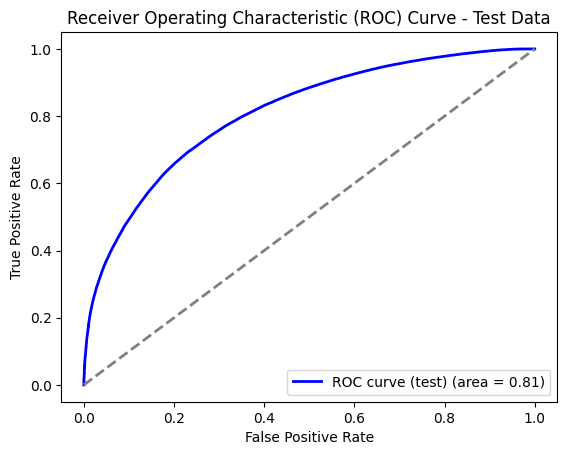

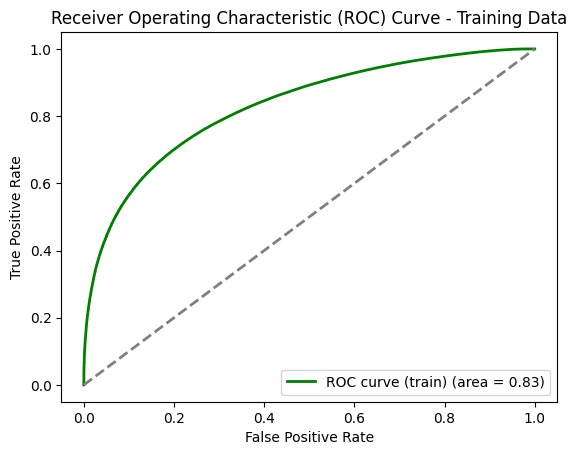

In [ ]:
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

# Define the models
from sklearn.ensemble import RandomForestClassifier
model_1 = RandomForestClassifier(random_state=42, max_depth=10)

model_2 = CatBoostClassifier(
    depth=10, learning_rate=0.1, iterations=500, 
    random_seed=42, verbose=0)

model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)

# Get probability predictions from both models
probs_1_test = model_1.predict_proba(X_test)
probs_2_test = model_2.predict_proba(X_test)

probs_1_train = model_1.predict_proba(X_train)
probs_2_train = model_2.predict_proba(X_train)

# Define model weights
weight_1 = 0.45  # Model 1 works well for class 0
weight_2 = 0.55  # Model 2 works well for class 1

# Compute weighted average of probabilities
weighted_probs_test = (weight_1 * probs_1_test) + (weight_2 * probs_2_test)
weighted_probs_train = (weight_1 * probs_1_train) + (weight_2 * probs_2_train)

# Apply argmax to get final class predictions
y_pred = np.argmax(weighted_probs_test, axis=1)
y_pred_proba = weighted_probs_test[:, 1]

y_train_pred = np.argmax(weighted_probs_train, axis=1)
y_train_pred_proba = weighted_probs_train[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Log Loss: {log_loss_value:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test:.4f}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test:.4f}\n")

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Log Loss: {train_log_loss:.4f}")
print(f"Train ROC AUC: {train_roc_auc:.4f}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train:.4f}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train:.4f}\n")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7419
Test Log Loss: 0.5149
Test ROC AUC: 0.8094
Test Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.66      0.65    111075
           1       0.80      0.79      0.79    189528

    accuracy                           0.74    300603
   macro avg       0.72      0.72      0.72    300603
weighted avg       0.74      0.74      0.74    300603

Class 0 Test Accuracy: 0.6578
Class 1 Test Accuracy: 0.7912

Train Accuracy: 0.7491
Train Log Loss: 0.5080
Train ROC AUC: 0.8292
Train Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.79      0.76    758110
           1       0.77      0.70      0.74    758110

    accuracy                           0.75   1516220
   macro avg       0.75      0.75      0.75   1516220
weighted avg       0.75      0.75      0.75   1516220

Class 0 Train Accuracy: 0.7936
Class 1 Train Accuracy: 0.7047



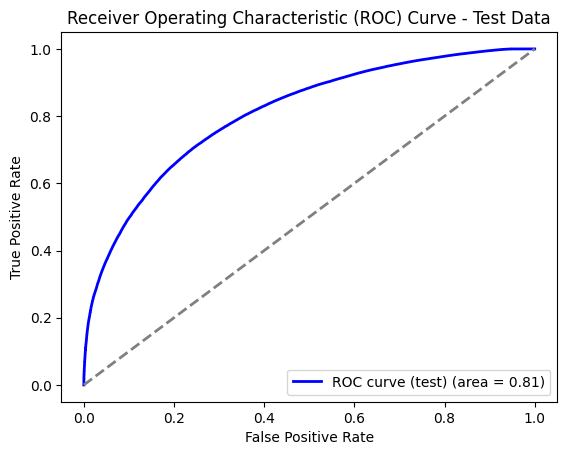

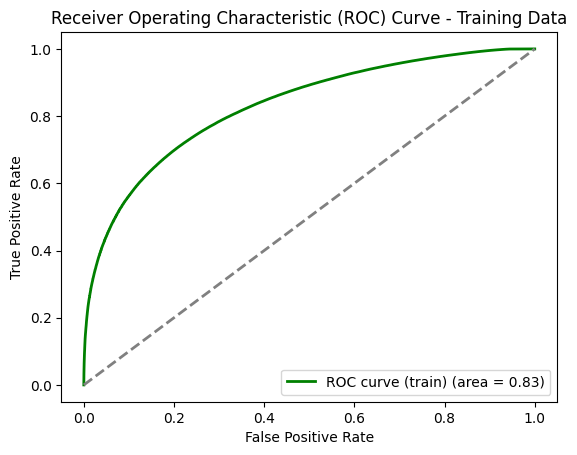

In [ ]:
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier

# Define the models
model_1 = CatBoostClassifier(
    depth=6, learning_rate=0.1, iterations=100, 
    random_seed=42, verbose=0)

model_2 = CatBoostClassifier(
    depth=10, learning_rate=0.1, iterations=500, 
    random_seed=42, verbose=0)

model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)

# Get probability predictions from both models
probs_1_test = model_1.predict_proba(X_test)
probs_2_test = model_2.predict_proba(X_test)

probs_1_train = model_1.predict_proba(X_train)
probs_2_train = model_2.predict_proba(X_train)

# Define model weights
weight_1 = 0.40  # Model 1 works well for class 0
weight_2 = 0.60  # Model 2 works well for class 1

# Compute weighted average of probabilities
weighted_probs_test = (weight_1 * probs_1_test) + (weight_2 * probs_2_test)
weighted_probs_train = (weight_1 * probs_1_train) + (weight_2 * probs_2_train)

# Apply argmax to get final class predictions
y_pred = np.argmax(weighted_probs_test, axis=1)
y_pred_proba = weighted_probs_test[:, 1]

y_train_pred = np.argmax(weighted_probs_train, axis=1)
y_train_pred_proba = weighted_probs_train[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Log Loss: {log_loss_value:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test:.4f}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test:.4f}\n")

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Log Loss: {train_log_loss:.4f}")
print(f"Train ROC AUC: {train_roc_auc:.4f}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train:.4f}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train:.4f}\n")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7380
Test Log Loss: 0.5215
Test ROC AUC: 0.8081
Test Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.68      0.66    111075
           1       0.81      0.77      0.79    189528

    accuracy                           0.74    300603
   macro avg       0.72      0.73      0.72    300603
weighted avg       0.74      0.74      0.74    300603

Class 0 Test Accuracy: 0.6824
Class 1 Test Accuracy: 0.7706

Train Accuracy: 0.7451
Train Log Loss: 0.5137
Train ROC AUC: 0.8247
Train Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.79      0.76    758110
           1       0.77      0.70      0.73    758110

    accuracy                           0.75   1516220
   macro avg       0.75      0.75      0.74   1516220
weighted avg       0.75      0.75      0.74   1516220

Class 0 Train Accuracy: 0.7893
Class 1 Train Accuracy: 0.7009



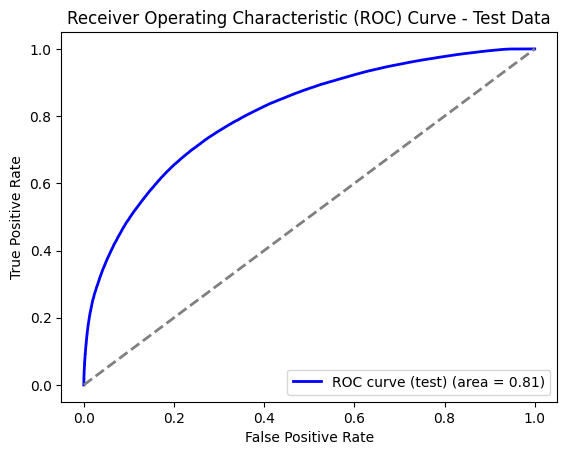

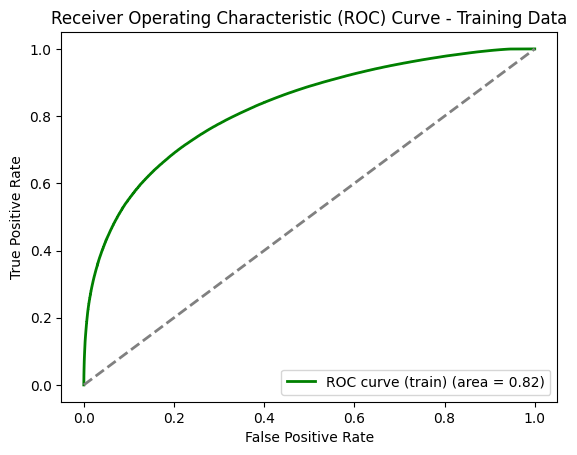

In [ ]:
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier

# Define the models
model_1 = CatBoostClassifier(
    depth=6, learning_rate=0.1, iterations=100, 
    random_seed=42, verbose=0)

model_2 = CatBoostClassifier(
    depth=10, learning_rate=0.1, iterations=500, 
    random_seed=42, verbose=0)

model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)

# Get probability predictions from both models
probs_1_test = model_1.predict_proba(X_test)
probs_2_test = model_2.predict_proba(X_test)

probs_1_train = model_1.predict_proba(X_train)
probs_2_train = model_2.predict_proba(X_train)

# Define model weights
weight_1 = 0.50  # Model 1 works well for class 0
weight_2 = 0.50  # Model 2 works well for class 1

# Compute weighted average of probabilities
weighted_probs_test = (weight_1 * probs_1_test) + (weight_2 * probs_2_test)
weighted_probs_train = (weight_1 * probs_1_train) + (weight_2 * probs_2_train)

# Apply argmax to get final class predictions
y_pred = np.argmax(weighted_probs_test, axis=1)
y_pred_proba = weighted_probs_test[:, 1]

y_train_pred = np.argmax(weighted_probs_train, axis=1)
y_train_pred_proba = weighted_probs_train[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Log Loss: {log_loss_value:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test:.4f}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test:.4f}\n")

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Log Loss: {train_log_loss:.4f}")
print(f"Train ROC AUC: {train_roc_auc:.4f}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train:.4f}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train:.4f}\n")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7428
Test Log Loss: 0.5092
Test ROC AUC: 0.8101
Test Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.64      0.65    111075
           1       0.79      0.80      0.80    189528

    accuracy                           0.74    300603
   macro avg       0.72      0.72      0.72    300603
weighted avg       0.74      0.74      0.74    300603

Class 0 Test Accuracy: 0.6419
Class 1 Test Accuracy: 0.8019

Train Accuracy: 0.7506
Train Log Loss: 0.5043
Train ROC AUC: 0.8310
Train Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.80      0.76    758110
           1       0.78      0.71      0.74    758110

    accuracy                           0.75   1516220
   macro avg       0.75      0.75      0.75   1516220
weighted avg       0.75      0.75      0.75   1516220

Class 0 Train Accuracy: 0.7958
Class 1 Train Accuracy: 0.7054



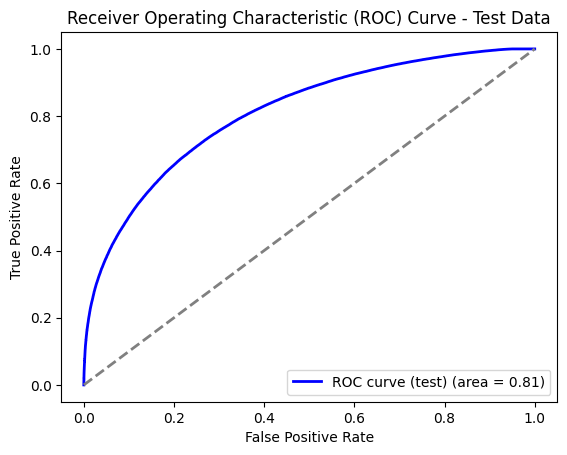

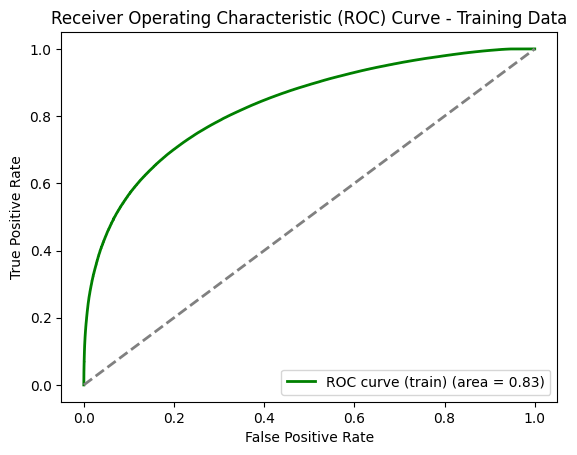

In [ ]:
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier

# Define the models
model_1 = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42
)

model_2 = CatBoostClassifier(
    depth=10, learning_rate=0.1, iterations=500, 
    random_seed=42, verbose=0)

model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)

# Get probability predictions from both models
probs_1_test = model_1.predict_proba(X_test)
probs_2_test = model_2.predict_proba(X_test)

probs_1_train = model_1.predict_proba(X_train)
probs_2_train = model_2.predict_proba(X_train)

# Define model weights
weight_1 = 0.40  # Model 1 works well for class 0
weight_2 = 0.60  # Model 2 works well for class 1

# Compute weighted average of probabilities
weighted_probs_test = (weight_1 * probs_1_test) + (weight_2 * probs_2_test)
weighted_probs_train = (weight_1 * probs_1_train) + (weight_2 * probs_2_train)

# Apply argmax to get final class predictions
y_pred = np.argmax(weighted_probs_test, axis=1)
y_pred_proba = weighted_probs_test[:, 1]

y_train_pred = np.argmax(weighted_probs_train, axis=1)
y_train_pred_proba = weighted_probs_train[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Log Loss: {log_loss_value:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test:.4f}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test:.4f}\n")

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Log Loss: {train_log_loss:.4f}")
print(f"Train ROC AUC: {train_roc_auc:.4f}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train:.4f}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train:.4f}\n")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7402
Test Log Loss: 0.5130
Test ROC AUC: 0.8094
Test Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.66      0.65    111075
           1       0.80      0.79      0.79    189528

    accuracy                           0.74    300603
   macro avg       0.72      0.72      0.72    300603
weighted avg       0.74      0.74      0.74    300603

Class 0 Test Accuracy: 0.6619
Class 1 Test Accuracy: 0.7861

Train Accuracy: 0.7472
Train Log Loss: 0.5087
Train ROC AUC: 0.8274
Train Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.79      0.76    758110
           1       0.77      0.70      0.74    758110

    accuracy                           0.75   1516220
   macro avg       0.75      0.75      0.75   1516220
weighted avg       0.75      0.75      0.75   1516220

Class 0 Train Accuracy: 0.7925
Class 1 Train Accuracy: 0.7020



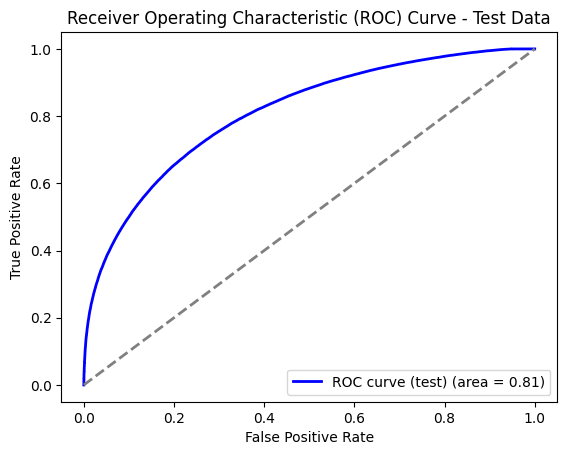

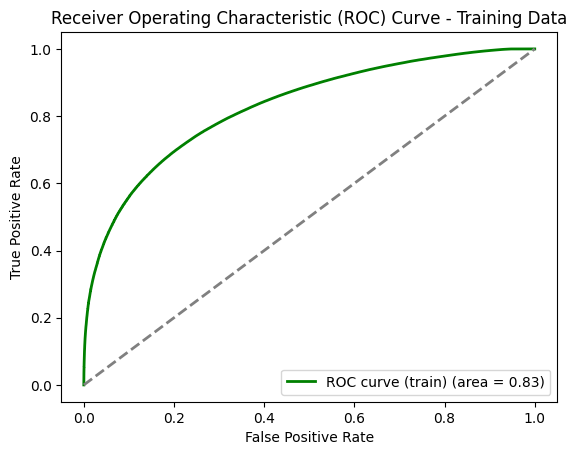

In [ ]:
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier

# Define the models
model_1 = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42
)

model_2 = CatBoostClassifier(
    depth=10, learning_rate=0.1, iterations=500, 
    random_seed=42, verbose=0)

model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)

# Get probability predictions from both models
probs_1_test = model_1.predict_proba(X_test)
probs_2_test = model_2.predict_proba(X_test)

probs_1_train = model_1.predict_proba(X_train)
probs_2_train = model_2.predict_proba(X_train)

# Define model weights
weight_1 = 0.50  # Model 1 works well for class 0
weight_2 = 0.50  # Model 2 works well for class 1

# Compute weighted average of probabilities
weighted_probs_test = (weight_1 * probs_1_test) + (weight_2 * probs_2_test)
weighted_probs_train = (weight_1 * probs_1_train) + (weight_2 * probs_2_train)

# Apply argmax to get final class predictions
y_pred = np.argmax(weighted_probs_test, axis=1)
y_pred_proba = weighted_probs_test[:, 1]

y_train_pred = np.argmax(weighted_probs_train, axis=1)
y_train_pred_proba = weighted_probs_train[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Log Loss: {log_loss_value:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test:.4f}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test:.4f}\n")

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Log Loss: {train_log_loss:.4f}")
print(f"Train ROC AUC: {train_roc_auc:.4f}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train:.4f}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train:.4f}\n")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7418
Test Log Loss: 0.5110
Test ROC AUC: 0.8098
Test Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.65      0.65    111075
           1       0.80      0.79      0.80    189528

    accuracy                           0.74    300603
   macro avg       0.72      0.72      0.72    300603
weighted avg       0.74      0.74      0.74    300603

Class 0 Test Accuracy: 0.6517
Class 1 Test Accuracy: 0.7947

Train Accuracy: 0.7490
Train Log Loss: 0.5065
Train ROC AUC: 0.8292
Train Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.79      0.76    758110
           1       0.77      0.70      0.74    758110

    accuracy                           0.75   1516220
   macro avg       0.75      0.75      0.75   1516220
weighted avg       0.75      0.75      0.75   1516220

Class 0 Train Accuracy: 0.7942
Class 1 Train Accuracy: 0.7038



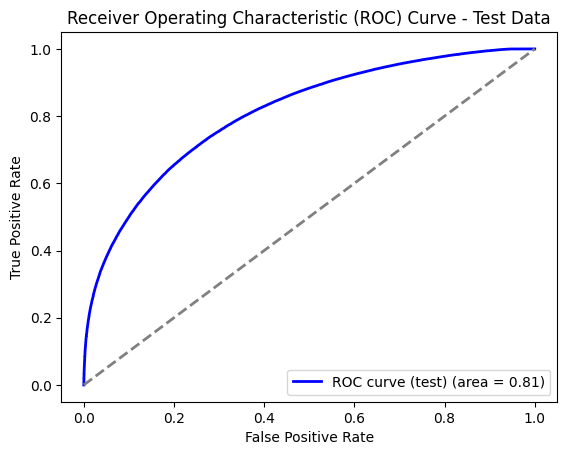

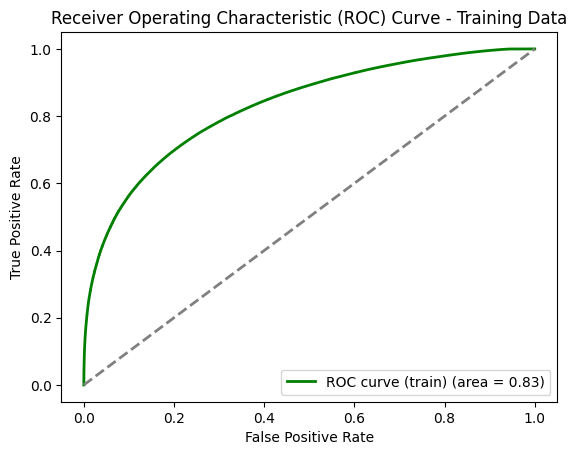

In [ ]:
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier

# Define the models
model_1 = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42
)

model_2 = CatBoostClassifier(
    depth=10, learning_rate=0.1, iterations=500, 
    random_seed=42, verbose=0)

model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)

# Get probability predictions from both models
probs_1_test = model_1.predict_proba(X_test)
probs_2_test = model_2.predict_proba(X_test)

probs_1_train = model_1.predict_proba(X_train)
probs_2_train = model_2.predict_proba(X_train)

# Define model weights
weight_1 = 0.45  # Model 1 works well for class 0
weight_2 = 0.55  # Model 2 works well for class 1

# Compute weighted average of probabilities
weighted_probs_test = (weight_1 * probs_1_test) + (weight_2 * probs_2_test)
weighted_probs_train = (weight_1 * probs_1_train) + (weight_2 * probs_2_train)

# Apply argmax to get final class predictions
y_pred = np.argmax(weighted_probs_test, axis=1)
y_pred_proba = weighted_probs_test[:, 1]

y_train_pred = np.argmax(weighted_probs_train, axis=1)
y_train_pred_proba = weighted_probs_train[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Log Loss: {log_loss_value:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test:.4f}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test:.4f}\n")

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Log Loss: {train_log_loss:.4f}")
print(f"Train ROC AUC: {train_roc_auc:.4f}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train:.4f}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train:.4f}\n")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7400
Test Log Loss: 0.5180
Test ROC AUC: 0.8089
Test Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.67      0.66    111075
           1       0.80      0.78      0.79    189528

    accuracy                           0.74    300603
   macro avg       0.72      0.73      0.72    300603
weighted avg       0.74      0.74      0.74    300603

Class 0 Test Accuracy: 0.6698
Class 1 Test Accuracy: 0.7812

Train Accuracy: 0.7473
Train Log Loss: 0.5108
Train ROC AUC: 0.8270
Train Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.79      0.76    758110
           1       0.77      0.70      0.74    758110

    accuracy                           0.75   1516220
   macro avg       0.75      0.75      0.75   1516220
weighted avg       0.75      0.75      0.75   1516220

Class 0 Train Accuracy: 0.7916
Class 1 Train Accuracy: 0.7029



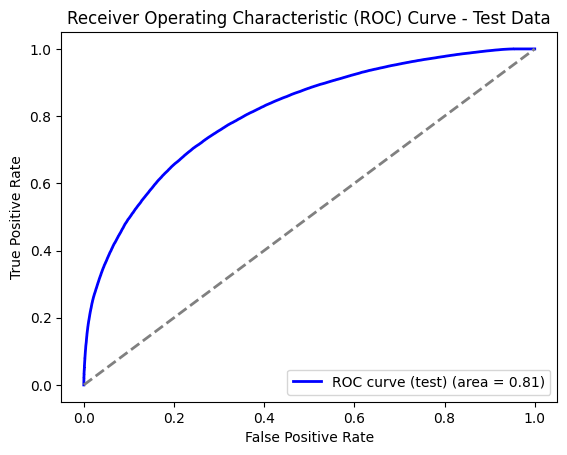

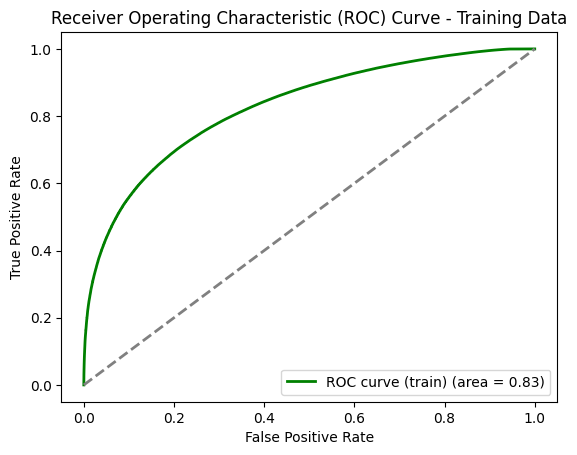

In [ ]:
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier

# Define the models
model_1 = CatBoostClassifier(
    depth=6, learning_rate=0.1, iterations=100, 
    random_seed=42, verbose=0)

model_2 = CatBoostClassifier(
    depth=10, learning_rate=0.1, iterations=500, 
    random_seed=42, verbose=0)

model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)

# Get probability predictions from both models
probs_1_test = model_1.predict_proba(X_test)
probs_2_test = model_2.predict_proba(X_test)

probs_1_train = model_1.predict_proba(X_train)
probs_2_train = model_2.predict_proba(X_train)

# Define model weights
weight_1 = 0.45  # Model 1 works well for class 0
weight_2 = 0.55  # Model 2 works well for class 1

# Compute weighted average of probabilities
weighted_probs_test = (weight_1 * probs_1_test) + (weight_2 * probs_2_test)
weighted_probs_train = (weight_1 * probs_1_train) + (weight_2 * probs_2_train)

# Apply argmax to get final class predictions
y_pred = np.argmax(weighted_probs_test, axis=1)
y_pred_proba = weighted_probs_test[:, 1]

y_train_pred = np.argmax(weighted_probs_train, axis=1)
y_train_pred_proba = weighted_probs_train[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Log Loss: {log_loss_value:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test:.4f}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test:.4f}\n")

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Log Loss: {train_log_loss:.4f}")
print(f"Train ROC AUC: {train_roc_auc:.4f}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train:.4f}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train:.4f}\n")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7432
Test Log Loss: 0.5122
Test ROC AUC: 0.8097
Test Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.65      0.65    111075
           1       0.79      0.80      0.80    189528

    accuracy                           0.74    300603
   macro avg       0.72      0.72      0.72    300603
weighted avg       0.74      0.74      0.74    300603

Class 0 Test Accuracy: 0.6461
Class 1 Test Accuracy: 0.8002

Train Accuracy: 0.7509
Train Log Loss: 0.5053
Train ROC AUC: 0.8312
Train Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.80      0.76    758110
           1       0.78      0.71      0.74    758110

    accuracy                           0.75   1516220
   macro avg       0.75      0.75      0.75   1516220
weighted avg       0.75      0.75      0.75   1516220

Class 0 Train Accuracy: 0.7954
Class 1 Train Accuracy: 0.7065



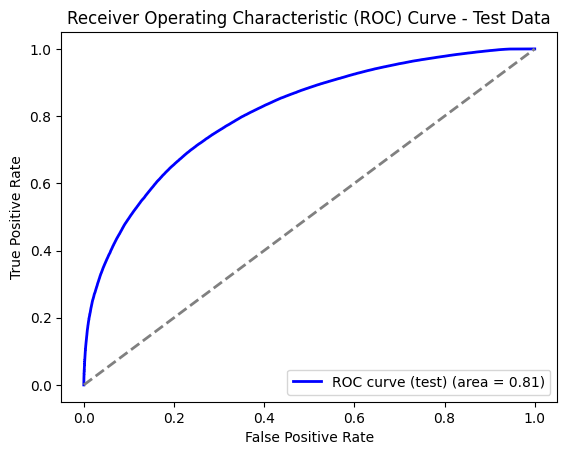

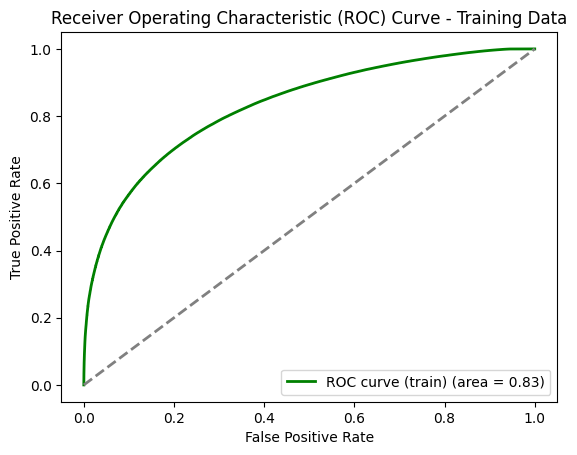

In [ ]:
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier

# Define the models
model_1 = CatBoostClassifier(
    depth=6, learning_rate=0.1, iterations=100, 
    random_seed=42, verbose=0)

model_2 = CatBoostClassifier(
    depth=10, learning_rate=0.1, iterations=500, 
    random_seed=42, verbose=0)

model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)

# Get probability predictions from both models
probs_1_test = model_1.predict_proba(X_test)
probs_2_test = model_2.predict_proba(X_test)

probs_1_train = model_1.predict_proba(X_train)
probs_2_train = model_2.predict_proba(X_train)

# Define model weights
weight_1 = 0.35  # Model 1 works well for class 0
weight_2 = 0.65  # Model 2 works well for class 1

# Compute weighted average of probabilities
weighted_probs_test = (weight_1 * probs_1_test) + (weight_2 * probs_2_test)
weighted_probs_train = (weight_1 * probs_1_train) + (weight_2 * probs_2_train)

# Apply argmax to get final class predictions
y_pred = np.argmax(weighted_probs_test, axis=1)
y_pred_proba = weighted_probs_test[:, 1]

y_train_pred = np.argmax(weighted_probs_train, axis=1)
y_train_pred_proba = weighted_probs_train[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Log Loss: {log_loss_value:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test:.4f}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test:.4f}\n")

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Log Loss: {train_log_loss:.4f}")
print(f"Train ROC AUC: {train_roc_auc:.4f}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train:.4f}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train:.4f}\n")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7323
Test Log Loss: 0.5298
Test ROC AUC: 0.8057
Test Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.71      0.66    111075
           1       0.81      0.75      0.78    189528

    accuracy                           0.73    300603
   macro avg       0.72      0.73      0.72    300603
weighted avg       0.74      0.73      0.74    300603

Class 0 Test Accuracy: 0.7087
Class 1 Test Accuracy: 0.7461

Train Accuracy: 0.7402
Train Log Loss: 0.5197
Train ROC AUC: 0.8195
Train Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75    758110
           1       0.76      0.70      0.73    758110

    accuracy                           0.74   1516220
   macro avg       0.74      0.74      0.74   1516220
weighted avg       0.74      0.74      0.74   1516220

Class 0 Train Accuracy: 0.7836
Class 1 Train Accuracy: 0.6968



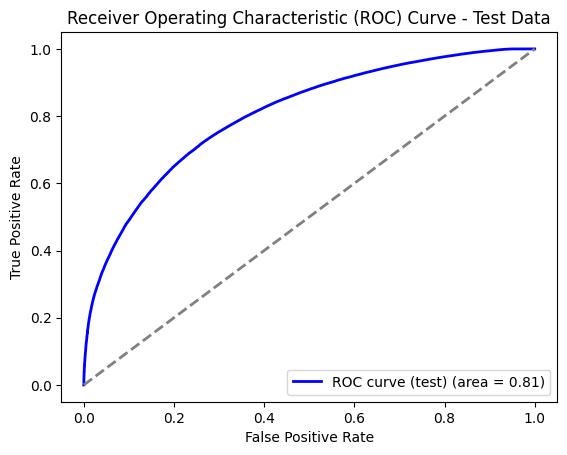

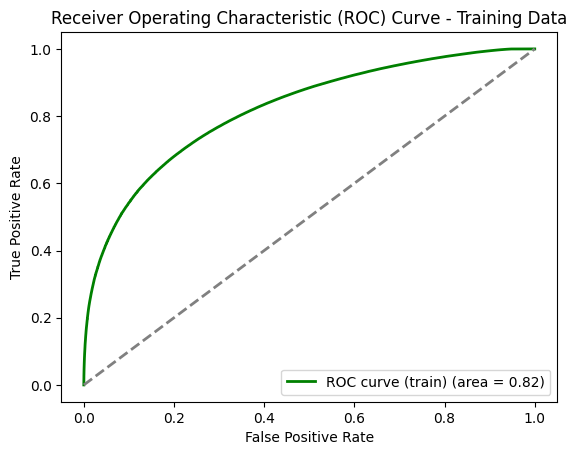

In [ ]:
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier

# Define the models
model_1 = CatBoostClassifier(
    depth=6, learning_rate=0.1, iterations=100, 
    random_seed=42, verbose=0)

model_2 = CatBoostClassifier(
    depth=10, learning_rate=0.1, iterations=500, 
    random_seed=42, verbose=0)

model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)

# Get probability predictions from both models
probs_1_test = model_1.predict_proba(X_test)
probs_2_test = model_2.predict_proba(X_test)

probs_1_train = model_1.predict_proba(X_train)
probs_2_train = model_2.predict_proba(X_train)

# Define model weights
weight_1 = 0.60  # Model 1 works well for class 0
weight_2 = 0.40  # Model 2 works well for class 1

# Compute weighted average of probabilities
weighted_probs_test = (weight_1 * probs_1_test) + (weight_2 * probs_2_test)
weighted_probs_train = (weight_1 * probs_1_train) + (weight_2 * probs_2_train)

# Apply argmax to get final class predictions
y_pred = np.argmax(weighted_probs_test, axis=1)
y_pred_proba = weighted_probs_test[:, 1]

y_train_pred = np.argmax(weighted_probs_train, axis=1)
y_train_pred_proba = weighted_probs_train[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Log Loss: {log_loss_value:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test:.4f}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test:.4f}\n")

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Log Loss: {train_log_loss:.4f}")
print(f"Train ROC AUC: {train_roc_auc:.4f}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train:.4f}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train:.4f}\n")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7442
Test Log Loss: 0.5099
Test ROC AUC: 0.8097
Test Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.63      0.65    111075
           1       0.79      0.81      0.80    189528

    accuracy                           0.74    300603
   macro avg       0.73      0.72      0.72    300603
weighted avg       0.74      0.74      0.74    300603

Class 0 Test Accuracy: 0.6347
Class 1 Test Accuracy: 0.8084

Train Accuracy: 0.7526
Train Log Loss: 0.5027
Train ROC AUC: 0.8331
Train Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.80      0.76    758110
           1       0.78      0.71      0.74    758110

    accuracy                           0.75   1516220
   macro avg       0.75      0.75      0.75   1516220
weighted avg       0.75      0.75      0.75   1516220

Class 0 Train Accuracy: 0.7971
Class 1 Train Accuracy: 0.7080



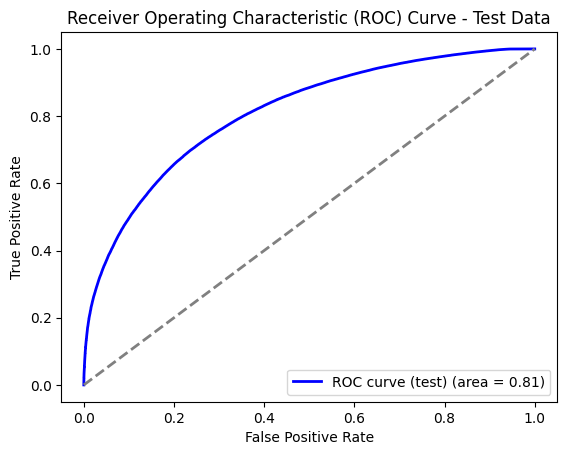

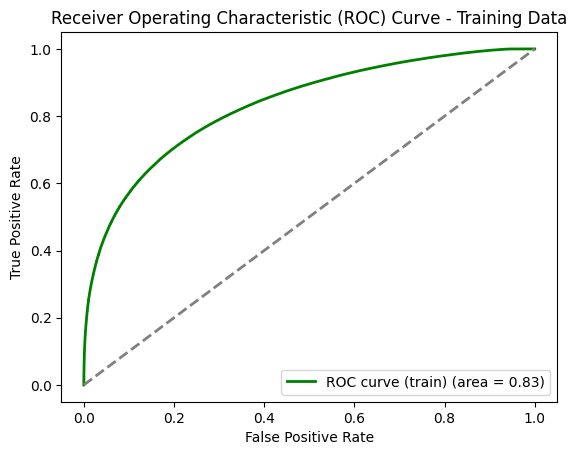

In [ ]:
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier

# Define the models
model_1 = CatBoostClassifier(
    depth=6, learning_rate=0.1, iterations=100, 
    random_seed=42, verbose=0)

model_2 = CatBoostClassifier(
    depth=10, learning_rate=0.1, iterations=500, 
    random_seed=42, verbose=0)

model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)

# Get probability predictions from both models
probs_1_test = model_1.predict_proba(X_test)
probs_2_test = model_2.predict_proba(X_test)

probs_1_train = model_1.predict_proba(X_train)
probs_2_train = model_2.predict_proba(X_train)

# Define model weights
weight_1 = 0.30  # Model 1 works well for class 0
weight_2 = 0.70  # Model 2 works well for class 1

# Compute weighted average of probabilities
weighted_probs_test = (weight_1 * probs_1_test) + (weight_2 * probs_2_test)
weighted_probs_train = (weight_1 * probs_1_train) + (weight_2 * probs_2_train)

# Apply argmax to get final class predictions
y_pred = np.argmax(weighted_probs_test, axis=1)
y_pred_proba = weighted_probs_test[:, 1]

y_train_pred = np.argmax(weighted_probs_train, axis=1)
y_train_pred_proba = weighted_probs_train[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Log Loss: {log_loss_value:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test:.4f}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test:.4f}\n")

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Log Loss: {train_log_loss:.4f}")
print(f"Train ROC AUC: {train_roc_auc:.4f}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train:.4f}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train:.4f}\n")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()